In [694]:
import matplotlib.pyplot as plt
import random
import math
import copy
import uuid
import pandas as pd
%matplotlib inline

In [ ]:
[10,12] # no size means this or the next (can be either orientation)
[12,12] # also for no size 
[15,21] # can be either orientation
[20,26] # can be either orientation
[22,22] # can be either
[26,38] # can be either
# add 1 in for each width-- so we've got x-small
# so in a 14 inch grid -- we can do: 
# xsmall within 1
# small within 2
[12, 14] # 1x1 # if we allow the 175 px to be 45 inches, then we're looking at 3.89 pixels per inch
[14, 14] # 1x1
[17, 23] # 2x2
[22, 28] # 2x2
[24, 24] # 2x2
[28, 40] # 2x3

In [565]:
PPI = 3

WTYPES = {'p_xsmall': [12*PPI, 14*PPI], 'l_xsmall': [14*PPI, 12*PPI],
              'xsmall': [14*PPI, 14*PPI], 'p_small': [17*PPI, 23*PPI], 'l_small': [23*PPI, 17*PPI],
              'p_medium': [22*PPI, 28*PPI], 'l_medium': [28*PPI, 22*PPI], 'medium': [24*PPI, 24*PPI],
              'p_large': [28*PPI, 40*PPI], 'l_large': [40*PPI, 28*PPI]}

ALIGN_CHOICES = ['bottom', 'top', 'left', 'right', 'centerx', 'centery']

DESTINATIONS = {'bottom': ['posx_top', 'posx_bottom', 'negx_top', 'negx_bottom'],
                     'top': ['posx_top', 'posx_bottom', 'negx_top', 'negx_bottom'],
                     'left': ['posy_left', 'posy_right', 'negy_left', 'negy_right'],
                     'right': ['posy_left', 'posy_right', 'negy_left', 'negy_right'],
                     'centerx': ['posy_centerx', 'negy_centerx', 'posy_left', 'negy_left', 'posy_right', 'negy_right'],
                      'centery': ['posx_centery', 'negx_centery', 'posx_top', 'negx_top', 'posx_bottom', 'posx_top']  
                        }

In [1043]:
"""Number of alignment choices per node"""
len(WTYPES) * sum([len(DESTINATIONS[ac]) for ac in ALIGN_CHOICES])

280

In [1035]:
# back to square 0 acting like its an optimization function -- we can set the space then fill it, 
# but there needs to be some sort of placement algorithm... probably a heuristic

# WTYPES = {'p_small': [17*PPI, 23*PPI], 'l_small': [23*PPI, 17*PPI]}

class Work():
    
    wtypes = WTYPES
    
    align_choices = ALIGN_CHOICES
    
    # goes desttranslate_destalign
    destinations = DESTINATIONS
    
    def __init__(self, wtype, ll_position=(0,0), creation_metadata=None):
        self.wtype = wtype
        self.id = str(uuid.uuid4())
        self.size = self.wtypes[wtype]
        self.ll_position = ll_position        
        self.creation_metadata = creation_metadata
        
    @property
    def bottom(self):
        return self.ll_position[1]
    
    @property
    def top(self):
        return self.ll_position[1]+self.size[1]
    
    @property
    def left(self):
        return self.ll_position[0]
    
    @property
    def right(self):
        return self.ll_position[0]+self.size[0]

    @property
    def centerx(self):
        return self.ll_position[0]+self.size[0]/2
    
    @property
    def centery(self):
        return self.ll_position[1]+self.size[1]/2

    @property
    def area(self):
        return self.size[0]*self.size[1]
    
    def rotate(self):
        if 'p_' in self.wtype:
            self.wtype.replace('p_', 'l_')
        elif 'l_' in self.wtype:
            self.wtype.replace('l_', 'p_')
        self.size = self.wtypes[self.wtype]
    
    def spawn_work(self, wtype='random', how_source='random', how_target='random', spacing=10*PPI):
        
        if wtype == 'random':
            wtype = random.choice(list(self.wtypes.keys()))
        
        if how_source == 'random':
            how_source = random.choice(self.align_choices)
        
        if how_target == 'random':
            how_target = random.choice(self.destinations[how_source])
        
        source_shared_loc = getattr(self, how_source)
        
        shift_dir, target_align = how_target.split('_')
        
        if shift_dir == 'posx':
            target_loc = self.ll_position[0]+self.size[0]+spacing
        elif shift_dir == 'posy':
            target_loc = self.ll_position[1]+self.size[1]+spacing
        elif shift_dir == 'negx':
            target_loc = self.ll_position[0]-spacing-self.wtypes[wtype][0]
        elif shift_dir == 'negy':
            target_loc = self.ll_position[1]-spacing-self.wtypes[wtype][1]
        
#         print(f"{how_source}->{how_target}")
#         print(source_shared_loc)
        
        if target_align == 'top':
            source_shared_loc -= self.wtypes[wtype][1]
        elif target_align == 'right':
            source_shared_loc -= self.wtypes[wtype][0]
        elif target_align == 'centerx':
            source_shared_loc -= self.wtypes[wtype][0]/2
        elif target_align == 'centery':
            source_shared_loc -= self.wtypes[wtype][1]/2
        
        if 'x' in shift_dir:
            new_pos = (target_loc, source_shared_loc)
        else:
            new_pos = (source_shared_loc, target_loc)
            
        return Work(wtype, new_pos, creation_metadata=f"{self.id}:{how_source}->{how_target}")

    
class WallSpace():
    
    def __init__(self, wallheight=80*PPI, wallwidth=80*PPI, nworks=4, seed_work='p_small', seed_position=None,
                symmetric_center=None):
        self.nworks = nworks
        self.height = wallheight
        self.width = wallwidth
        if seed_position is None:
            seed_position = (self.width/2-Work.wtypes[seed_work][0]/2, self.height/2-Work.wtypes[seed_work][1]/2)    
        self.works = [Work(seed_work, ll_position=seed_position)]
        self.symmetric_center = symmetric_center
        if symmetric_center is None:
            self.symmetric_center = (self.works[0].centerx, self.works[0].centery)
    
    def show_wall(self):
        plt.axes()
        for work in self.works:
            rectangle = plt.Rectangle(work.ll_position, work.size[0], work.size[1], fc='r', lw=1, ec='k')
            plt.gca().add_patch(rectangle)

        plt.axis('scaled')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()
    
    
    def symmetry(self, works):
        # calculate the symmetry here 
        symmetryx = 0
        symmetryy = 0
        totarea = 0
        for work in works:
            totarea += work.area
            symmetryx += work.area * (work.centerx - self.symmetric_center[0])
            symmetryy += work.area * (work.centery - self.symmetric_center[1])
            
        return math.sqrt((symmetryx/totarea)**2 + (symmetryy/totarea)**2)
    
    @property
    def average_separation(self):
        # get the average centroid distance n^2 calc for the works
        total_average_dist = 0
        for work in self.works:
            dist = 0
            for dwork in self.works:
                
                if work.id != dwork.id:
                    xdist = abs(work.centerx - dwork.centerx) - (work.size[0]/2 + dwork.size[0]/2)
                    ydist = abs(work.centery - dwork.centery) - (work.size[1]/2 + dwork.size[1]/2)
                    dist += math.sqrt(xdist**2 + ydist**2)
                    
            total_average_dist += dist / (len(self.works)-1)
        return total_average_dist
    
    @property
    def magic_metric(self):
        return (2*self.symmetry + 0*self.average_separation) / (2.)
        
    def check_valid(self, testwork, spacing=10*PPI):
        
        if testwork.bottom < 0:
            return False
        elif testwork.left < 0:
            return False
        elif testwork.right > self.width:
            return False
        elif testwork.top > self.height:
            return False
        
        # look at all the art to see it's overlapping
        for work in self.works:
            if abs(testwork.centerx - work.centerx) < (testwork.size[0]/2. + work.size[0]/2. + spacing) and \
                 abs(testwork.centery - work.centery) < (testwork.size[1]/2. + work.size[1]/2. + spacing):
                return False
        
        return True
    
    def realign_center(self):
        
        weighted_centroidx = sum([work.centerx*work.area for work in self.works]) / sum([work.area for work in self.works])
        weighted_centroidy = sum([work.centery*work.area for work in self.works]) / sum([work.area for work in self.works])
#         print(weighted_centroidx, weighted_centroidy)
#         print(self.width / 2 , self.height / 2)
        for work in self.works:
            work.ll_position = (work.ll_position[0] + (self.width / 2 - weighted_centroidx),
                                work.ll_position[1] + (self.height / 2 - weighted_centroidy))
    
#     def _chain_of_works(self, seed_works, n, spacing):
        
#         chain_works = []
        
#         while 
        
#         tmp_work = seed_work.spawn_work(spacing=spacing)
        
#         if self.check_valid(tmp_work, spacing=spacing):
    
    def _single_wall(self, spacing, trialloops, maxloops, pruning=False):
        # recursively search going down at least N layers deep for the best symmetry
        
        while len(self.works) < self.nworks:
            
            # loop across all works
            tmp_works = []

            for seed_work in copy.copy(self.works):
                
                loopn = 0
                
                while (loopn < trialloops) or (loopn < maxloops and len(tmp_works) == 0):
                    
                    # here we can pull out seed works
                    tmp_work = seed_work.spawn_work(spacing=spacing)
                    
                    if self.check_valid(tmp_work, spacing=spacing):
                        self.works.append(tmp_work)
                        tmp_works.append((tmp_work, copy.copy(self.magic_metric)))
                        self.works = self.works[:-1]
                    loopn+=1

            if len(tmp_works) == 0:
                break
                
            else:
                seedcount = 0
                self.works.append(sorted(tmp_works, key=lambda x: x[1])[0][0])
                
        if pruning:
            keeps = random.randint(1,min(3, len(self.works)-1))
            self.works = random.sample(self.works, len(self.works)-keeps)
            self._single_wall(spacing, trialloops, maxloops, False)
    
    def generate_wall(self, spacing=10*PPI, trialloops=50, maxloops=1000, epics=1000, pruning=True):
        
        initial_works = copy.copy(self.works)
        epic_candidates = []
        
        for epic in range(epics):
            if epic%100 == 0 and epic > 0:
                print(f'EPIC: {epic}')
            self.works = copy.copy(initial_works)
            self._single_wall(spacing, trialloops, maxloops, pruning)
            epic_candidates.append((copy.copy(self.works), copy.copy(self.magic_metric)))
        
        self.works = sorted(epic_candidates, key=lambda x: x[1])[0][0]
        
#         self.realign_center()

        return pd.DataFrame({'symmetries': [s[1] for s in epic_candidates]})
                

EPIC: 100
EPIC: 200
EPIC: 300
EPIC: 400
EPIC: 500
EPIC: 600
EPIC: 700
EPIC: 800
EPIC: 900


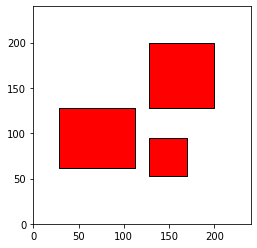

In [1045]:
ws = WallSpace(nworks=3, seed_work='medium', seed_position=(40*PPI+5*PPI/2, 40*PPI+5*PPI/2), symmetric_center=(40*PPI, 40*PPI))
sym = ws.generate_wall(spacing=5*PPI, pruning=False)
ws.show_wall()

In [810]:
print([(w.id, w.ll_position) for w in ws.works])
print([w.creation_metadata for w in ws.works])

[('2f1f1372-e76c-4d1b-9586-a8aa7947262d', (10, 94.5)), ('b8d40310-e309-4cfd-b416-d59edf4656eb', (94, 87.0)), ('57ffcc5d-29b9-4359-828a-ca17bd224bd2', (193, 99.0)), ('b49e8daa-598b-4294-b894-f3530d16520a', (115.0, 36.0)), ('c5ea092c-a35d-415e-b071-ea38c8b5e8de', (94, 168.0))]
[None, '2f1f1372-e76c-4d1b-9586-a8aa7947262d:centery->posx_centery', 'b8d40310-e309-4cfd-b416-d59edf4656eb:centery->posx_centery', 'b8d40310-e309-4cfd-b416-d59edf4656eb:centerx->negy_centerx', 'b8d40310-e309-4cfd-b416-d59edf4656eb:left->posy_left']


In [ ]:
# maybe the symmetry shouldn't be based on raw distance, but rather the gap distance times the area...

In [113]:
a=[(1,10), (2,-1)]

AttributeError: 'list' object has no attribute 'head'

centerx
118.0


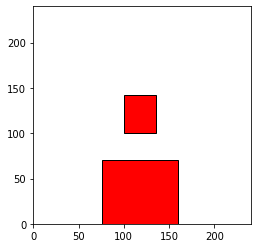

In [111]:
work = Work('p_xsmall', ll_position=(100,100))
nwork = work.spawn_work()
plot_boxes([work, nwork])